# Eco-Friendly Athletic Wear - Decision Trees

## Introduction

We’ll explore decision trees using real customer data from an
eco-friendly athletic wear collection. This analysis will help
understand which customer segments are most likely to purchase
sustainable athletic wear products priced 30-40% higher than standard
lines.

## Scenario: EcoAthletic Online Shopping Analysis

In October 2023, a major athletic wear retailer analyzed customer
behavior for their new sustainable athletic wear collection. This
premium line features workout gear made from recycled materials and
eco-friendly production methods, priced 30-40% higher than their
standard lines.

### Data Collection Method:

-   Tracked logged-in users who viewed sustainable collection items for
    \>2 minutes
-   Collected through website analytics and customer account data
-   Data includes both desktop and mobile browsers
-   Time period: October 1-31, 2023
-   Total unique viewers: ~3000, Analysis sample: 400

### Target Variable:

-   Whether a viewer made any sustainable collection purchase within 7
    days of browsing

### Customer Data Available:

-   Gender: Male/Female (from account info)
-   Age Group: Young (18-35) / Adult (36+)
-   Marital Status: Married/Not Married
-   Has Children: Yes/No (derived from previous purchase history)

### Data Split:

-   Training Data: 280 viewers from first 3 weeks
-   Testing Data: 120 viewers from final week

In [ ]:
def clean_tree_text(tree_text):
    # Dictionary of all replacements
    replacements = {
        "gender_F <= 0.50": "Male?",
        "gender_F >  0.50": "Female?",
        "gender_M <= 0.50": "Female?",
        "gender_M >  0.50": "Male?",
        "has_kids_No <= 0.50": "Has Kids?",
        "has_kids_No >  0.50": "No Kids?",
        "has_kids_Yes <= 0.50": "No Kids?",
        "has_kids_Yes >  0.50": "Has Kids?",
        "age_Young <= 0.50": "Adult?",
        "age_Young >  0.50": "Young?",
        "age_Adult <= 0.50": "Young?",
        "age_Adult >  0.50": "Adult?",
        "married_Yes <= 0.50": "Not Married?",
        "married_Yes >  0.50": "Married?",
        "class:": ""
    }
    
    # Apply all replacements
    clean_text = tree_text
    for old, new in replacements.items():
        clean_text = clean_text.replace(old, new)
    
    return clean_text

def print_clean_tree(classifier, columns):
    tree_text = export_text(classifier, feature_names=list(columns))
    print("\nDecision Tree:")
    print(clean_tree_text(tree_text))

def print_tree(classifier, columns):
    tree_text = export_text(classifier, feature_names=list(columns))
    print("\nDecision Tree:")
    print(tree_text)

def calculate_demographic_rates(test_data, predictions, demographic_col):
    """
    Calculate actual vs predicted purchase rates for a demographic category
    
    Parameters:
    test_data: DataFrame containing the test data
    predictions: Array of predicted values
    demographic_col: String name of demographic column to analyze
    
    Returns:
    DataFrame with actual and predicted rates by demographic category
    """
    # Create a DataFrame with actual and predicted values
    analysis_df = pd.DataFrame({
        'demographic': test_data[demographic_col],
        'actual': test_data['purchased'] == 'Yes',
        'predicted': predictions == 'Yes'
    })
    
    # Calculate rates by demographic
    results = []
    for demo in analysis_df['demographic'].unique():
        demo_mask = analysis_df['demographic'] == demo
        demo_data = analysis_df[demo_mask]
        
        actual_rate = demo_data['actual'].mean()
        predicted_rate = demo_data['predicted'].mean()
        count = len(demo_data)
        
        results.append({
            'Category': demo,
            'Count': count,
            'Actual Purchase Rate': f"{actual_rate:.1%}",
            'Predicted Purchase Rate': f"{predicted_rate:.1%}",
            'Difference': f"{(predicted_rate - actual_rate):.1%}"
        })
    
    return pd.DataFrame(results)

## The Training Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import confusion_matrix

# Training data goes here
train = pd.read_csv('sustainable_athletic_train.csv')

print("Training Data Summary:")
print(f"Number of records: {len(train)}")
print("\nSample of training data (first 10 records):")
print(train.head(10))

# Print some basic statistics
print("\nPurchase Rate in Training Data:")
print(f"Purchase Rate: {(train['purchased'] == 'Yes').mean():.1%}")
print("\nDemographic Breakdowns:")
print("\nBy Age:")
print(train['age'].value_counts(normalize=True))
print("\nBy Gender:")
print(train['gender'].value_counts(normalize=True))

## The Testing Data

In [ ]:
# Testing data goes here
test = pd.read_csv('sustainable_athletic_test.csv')

print("Testing Data Summary:")
print(f"Number of records: {len(test)}")
print("\nSample of testing data (first 10 records):")
print(test.head(10))

# Print some basic statistics
print("\nPurchase Rate in Testing Data:")
print(f"Purchase Rate: {(test['purchased'] == 'Yes').mean():.1%}")
print("\nDemographic Breakdowns:")
print("\nBy Age:")
print(test['age'].value_counts(normalize=True))
print("\nBy Gender:")
print(test['gender'].value_counts(normalize=True))

## The Decision Tree Classifier

In [ ]:
# Build the model using all predictors
X_train = pd.get_dummies(train[['age', 'gender', 'married', 'has_kids']])
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train, train['purchased'])

# Print the decision tree
print("\nDecision Tree for Sustainable Athletic Wear Purchase Prediction:")
print_clean_tree(classifier, X_train.columns)

![Decision Tree
Diagram](https://www.mermaidchart.com/raw/d148f5ac-3181-4740-ae5a-e6542cce3623?theme=light&version=v0.1&format=svg)

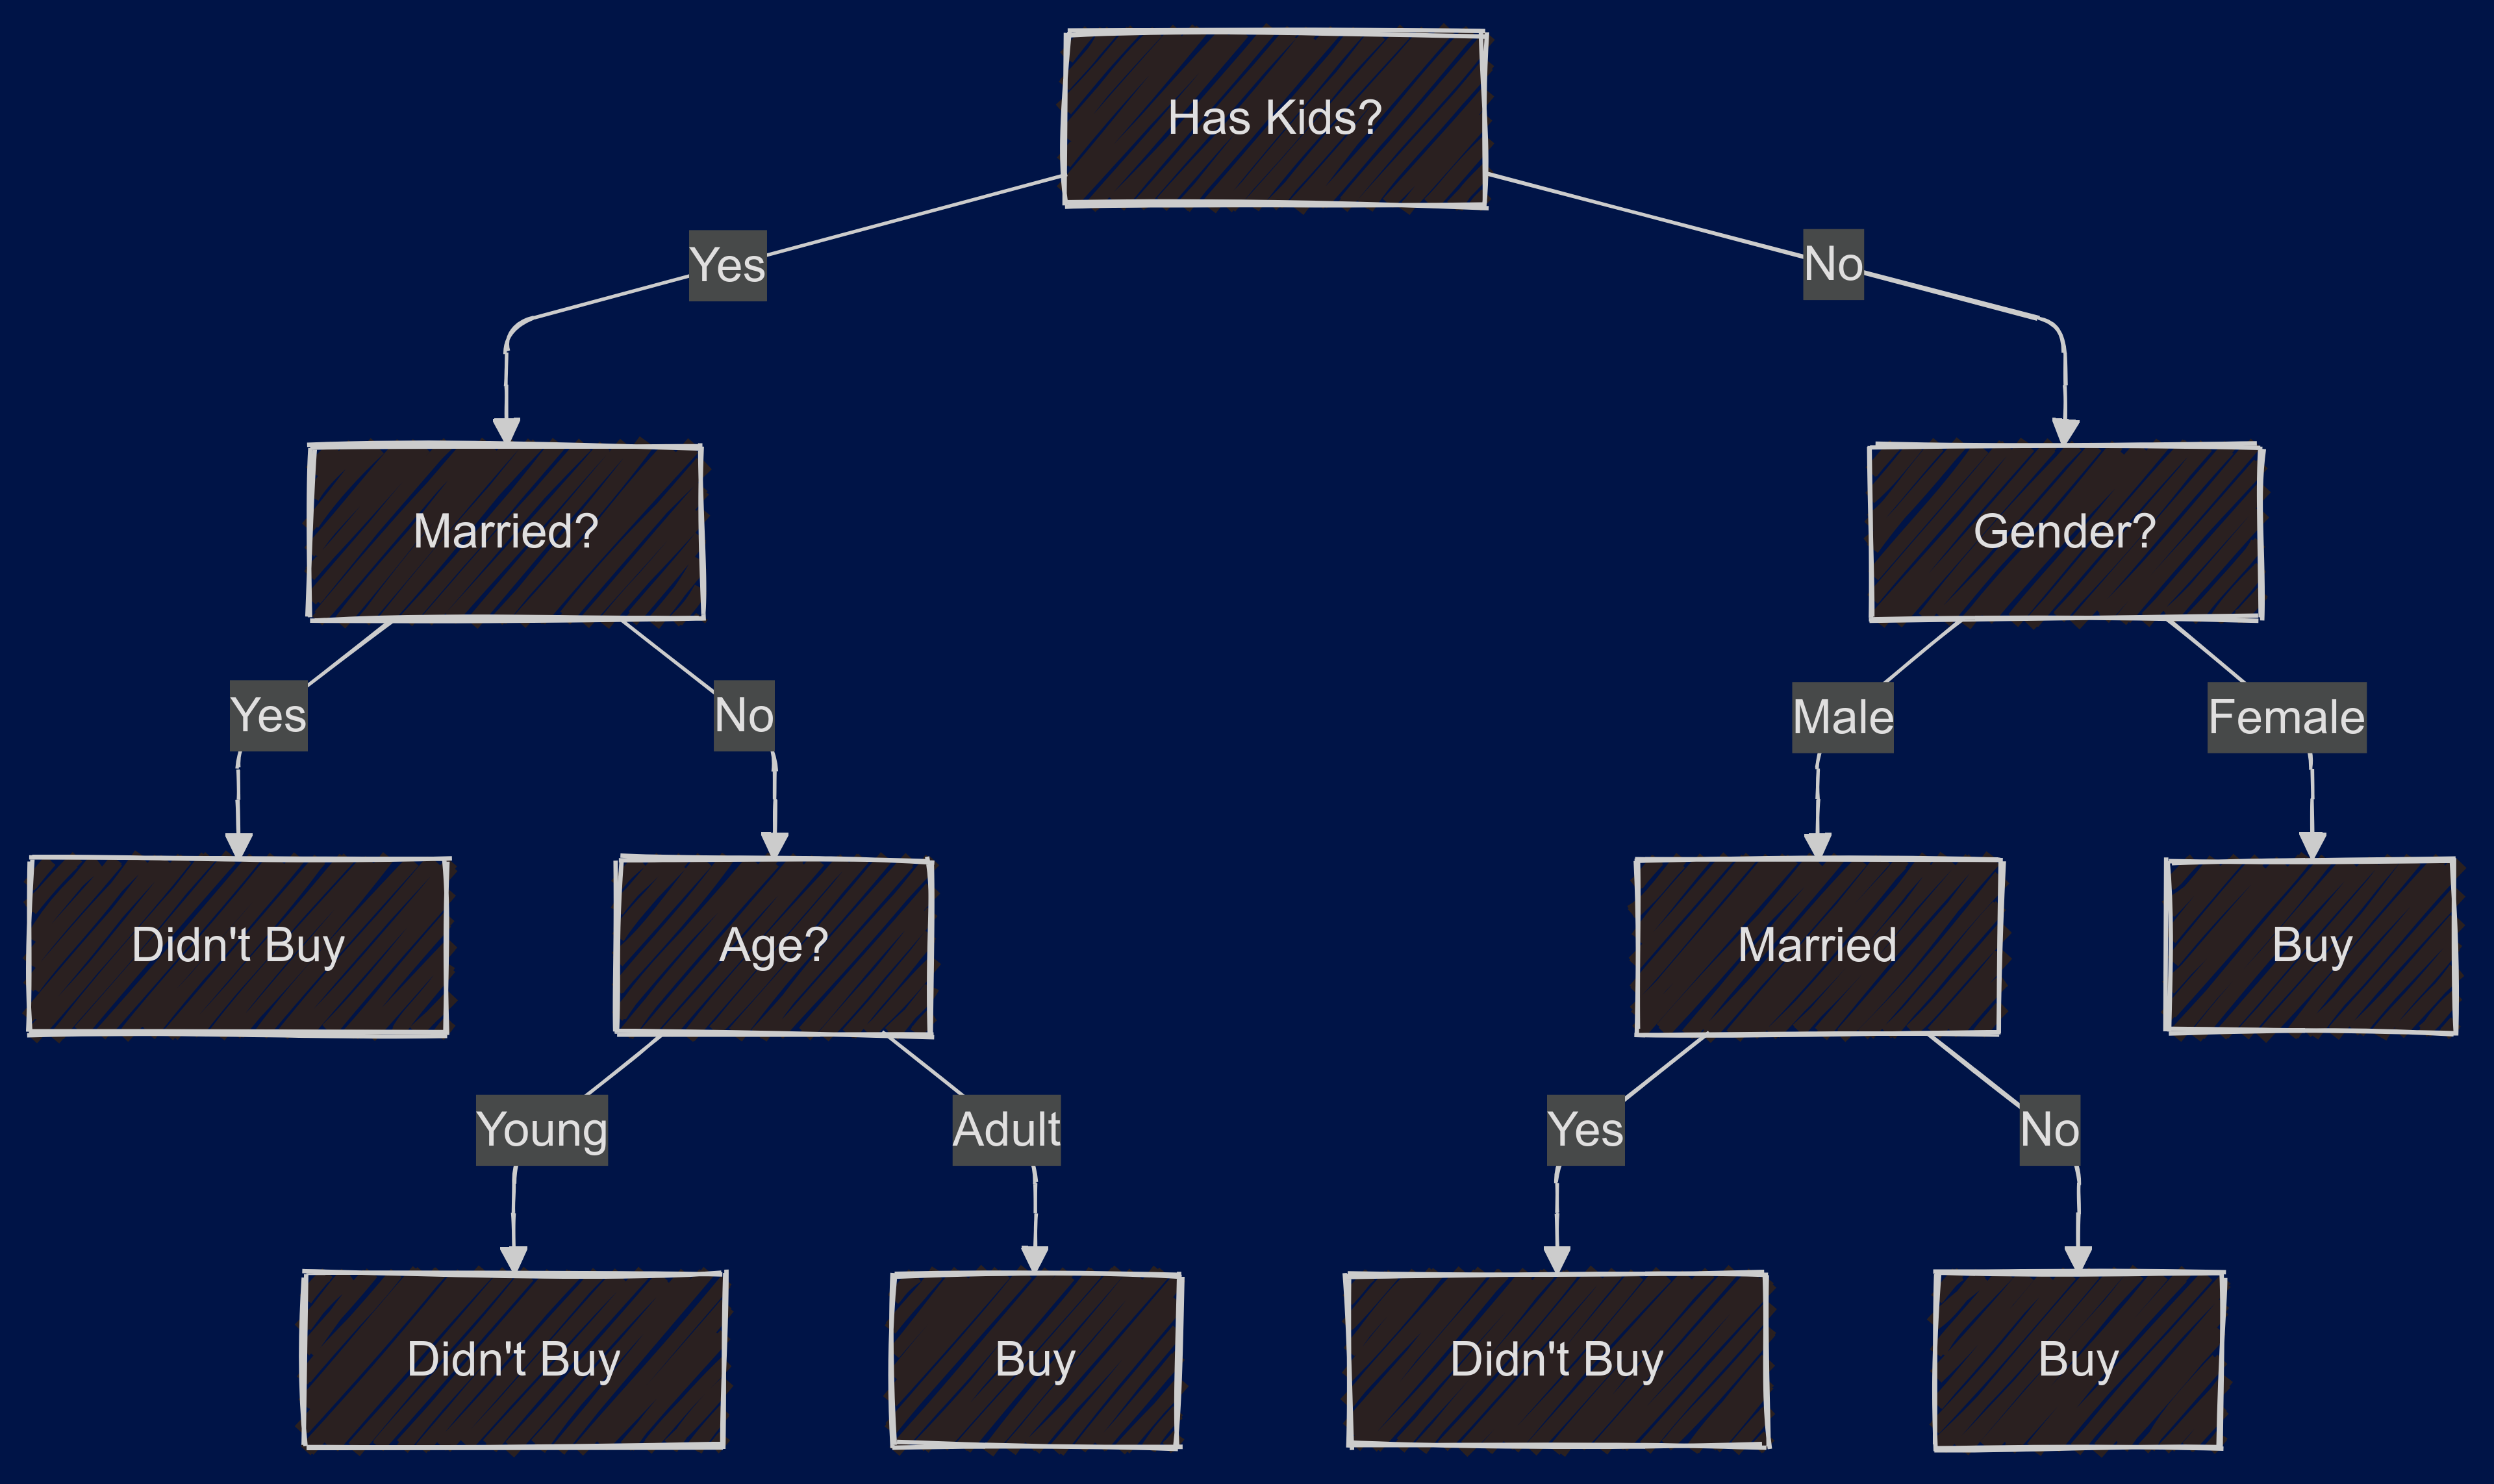

## Making Predictions on the Test Data

In [ ]:
# Make predictions
X_test = pd.get_dummies(test[['age', 'gender', 'married', 'has_kids']])
predictions = classifier.predict(X_test)

## Print confusion matrix

In [ ]:
cm = confusion_matrix(test['purchased'], predictions)
cm_df = pd.DataFrame(
    cm,
    index=['Actual: No Purchase', 'Actual: Purchased'],
    columns=['Predicted: No Purchase', 'Predicted: Purchased']
)
print("\nConfusion Matrix (Testing Results):")
print(cm_df)

## Accuracy

In [ ]:
# Calculate and print accuracy
correct = cm[0,0] + cm[1,1]
total = cm[0,0] + cm[1,1] + cm[1,0] + cm[0,1]
accuracy = correct/total
print(f"\nModel Accuracy: {accuracy:.2%}")

## Print Feature Importances

In [ ]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': classifier.feature_importances_
})
print("\nFeature Importances (Which customer characteristics matter most):")
print(importances.sort_values('importance', ascending=False))

In [ ]:
# Calculate rates by age
age_analysis = calculate_demographic_rates(test, predictions, 'age')
print("\nPurchase Rates by Age Group:")
print(age_analysis)

# Calculate rates by gender
gender_analysis = calculate_demographic_rates(test, predictions, 'gender')
print("\nPurchase Rates by Gender:")
print(gender_analysis)

## Analysis and Business Insights

### Model Performance and Prediction Analysis

The decision tree model achieved an 80.83% accuracy rate, but shows some
significant biases in its predictions that we need to consider:

1.  Gender Prediction Bias:
    -   Female Customers: Model substantially overestimates purchases
        -   Actual Rate: 21.7%
        -   Predicted Rate: 46.7%
        -   25.0 percentage point overestimation
    -   Male Customers: Model significantly underestimates purchases
        -   Actual Rate: 21.7%
        -   Predicted Rate: 11.7%
        -   -10.0 percentage point underestimation
    -   Notable that actual purchase rates are identical between genders
        (21.7%)
2.  Age Group Prediction Bias:
    -   Young Customers (18-35):
        -   Actual Rate: 27.7%
        -   Predicted Rate: 44.6%
        -   16.9 percentage point overestimation
    -   Adult Customers (36+):
        -   Actual Rate: 14.5%
        -   Predicted Rate: 10.9%
        -   -3.6 percentage point underestimation
3.  Key Feature Importances:
    -   Having children is the most important predictor (0.706)
    -   Age is the second most important feature (0.166)
    -   Marital status and gender have similar, lower importance
        (~0.052)

### Implications for Business Decisions

1.  Model Strengths:
    -   Strong overall accuracy at 80.83%
    -   Effectively identifies the importance of family status
    -   Clear decision patterns in the tree structure
2.  Model Limitations:
    -   Significant gender bias: overestimates female purchases by 25
        points
    -   Substantial age bias: overestimates young customer purchases by
        16.9 points
    -   Fails to recognize the actual equal purchase rates between
        genders
3.  Recommendations:
    -   Prioritize family status in segmentation (highest importance
        feature)
    -   Use caution with gender-based predictions due to demonstrated
        bias
    -   Consider retraining model with balanced class weights
    -   Implement continuous monitoring of predictions vs. actuals
4.  Business Strategy Adjustments:
    -   Focus primarily on family status for targeting decisions
    -   Develop marketing strategies that don’t discriminate by gender
    -   Consider separate models for different age groups
    -   Implement A/B testing to validate model predictions